In [47]:
import numpy as np
import matplotlib.pyplot as plt

import camb
from scipy.interpolate import interp1d

In [48]:
#generate Power spectrum

Omega_b = 0.05
Omega_c = 0.25

h=0.7
As = 2.1e-9
ns = 0.96

pars = camb.CAMBparams()
pars.set_cosmology(H0=100*h, ombh2=Omega_b*h**2, omch2=Omega_c*h**2)
pars.InitPower.set_params(As=As, ns=ns)

class: <InitialPowerLaw>
 tensor_parameterization = tensor_param_rpivot
 ns = 0.96
 nrun = 0.0
 nrunrun = 0.0
 nt = -0.0
 ntrun = -0.0
 r = 0.0
 pivot_scalar = 0.05
 pivot_tensor = 0.05
 As = 2.1e-09
 At = 1.0
 

In [49]:
pars.set_matter_power(redshifts=[1.], kmax=100.0)
results = camb.get_results(pars)

In [50]:
kh, z ,pk = results.get_matter_power_spectrum(minkh=1e-5, maxkh=100, npoints = 512)

Text(0, 0.5, '$P(k) [h^{-3} \\mathrm{Mpc}^{3}]$')

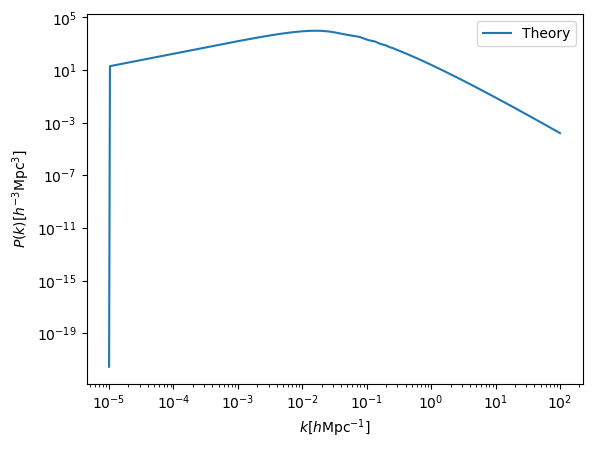

In [51]:
#Plot Power Spectrum
plt.loglog(kh, pk[0], label = 'Theory')
plt.legend(loc='best')
plt.xlabel(r"$k [h \mathrm{Mpc}^{-1}]$")
plt.ylabel(r"$P(k) [h^{-3} \mathrm{Mpc}^{3}]$")

#come l'altra volta si vede BAO a k = 10 alla -1

In [52]:
#Create an interpolator for the power spectrum
pk_interpolate = interp1d(kh, pk[0], kind='cubic', fill_value='extrapolate')

## Create the Grid


In [53]:
side = 500 #lato  è 500 Mpc
Volume = side**3

#number of cells per side
n_cells = 100
spacing = side/n_cells

print(spacing)
#tutto quello sotto i 5 Mpc per me è ugiuale

5.0


In [54]:
#fundamntal frequency
kF = 2*np.pi/side
#frequency of Nyquist(freq piu grande della mia distribuz)
kN = 2*np.pi/spacing
print(kF, "h/Mpc", kN, "h/Mpc") 

0.012566370614359173 h/Mpc 1.2566370614359172 h/Mpc


In [55]:
#voglio generare campo densita nello spazio do fourier
#poi farò trasformata per ottenere la mappa

#scrivo i valori di k che corrispondono ai ptio griglia
kx = np.fft.fftfreq(n_cells, d=spacing)*2*np.pi
ky = np.fft.fftfreq(n_cells, d=spacing)*2*np.pi 
kz = np.fft.rfftfreq(n_cells, d=spacing)*2*np.pi #metto r perche cosi impongo che sia reale (cioè impongo che sia hermitiana cosi da conservare memoria-->infatti ho la metà di celle)

print(kx.shape, ky.shape, kz.shape) 

(100,) (100,) (51,)


In [56]:
kx = np.fft.fftshift(kx)
ky = np.fft.fftshift(ky)
#uso lo shift per ordinarmi in modo crescente i valori di kx e ky


In [57]:
kx

array([-0.62831853, -0.61575216, -0.60318579, -0.59061942, -0.57805305,
       -0.56548668, -0.55292031, -0.54035394, -0.52778757, -0.5152212 ,
       -0.50265482, -0.49008845, -0.47752208, -0.46495571, -0.45238934,
       -0.43982297, -0.4272566 , -0.41469023, -0.40212386, -0.38955749,
       -0.37699112, -0.36442475, -0.35185838, -0.33929201, -0.32672564,
       -0.31415927, -0.30159289, -0.28902652, -0.27646015, -0.26389378,
       -0.25132741, -0.23876104, -0.22619467, -0.2136283 , -0.20106193,
       -0.18849556, -0.17592919, -0.16336282, -0.15079645, -0.13823008,
       -0.12566371, -0.11309734, -0.10053096, -0.08796459, -0.07539822,
       -0.06283185, -0.05026548, -0.03769911, -0.02513274, -0.01256637,
        0.        ,  0.01256637,  0.02513274,  0.03769911,  0.05026548,
        0.06283185,  0.07539822,  0.08796459,  0.10053096,  0.11309734,
        0.12566371,  0.13823008,  0.15079645,  0.16336282,  0.17592919,
        0.18849556,  0.20106193,  0.2136283 ,  0.22619467,  0.23

In [58]:
#Generation of Gaussian field in Fourier space
pks = np.zeros((n_cells, n_cells, n_cells//2+1))
#pks.shape

#i lungo x, j lungo y, k lungo z
#Per ogni pto della cella sto trovando le sue coordinate
for i in range(n_cells):
    kx = i if i <= n_cells//2 else i - n_cells #cioe se i < n_cells//2 allora kx = i altrimenti kx = i - n_cells
    kx *= 2*np.pi/side
    for j in range(n_cells):
        ky = j if j <= n_cells//2 else j - n_cells
        ky *= 2*np.pi/side
        for k in range(n_cells//2+1): #un po' diverso da prima perche ho solo valori positivi 
            kz = k + 2*np.pi/side
            knorm = np.sqrt(kx**2 + ky**2 + kz**2)
            if knorm == 0:
                pks[i,j,k] = 0
            else:   
                pks[i,j,k] = pk_interpolate(knorm)


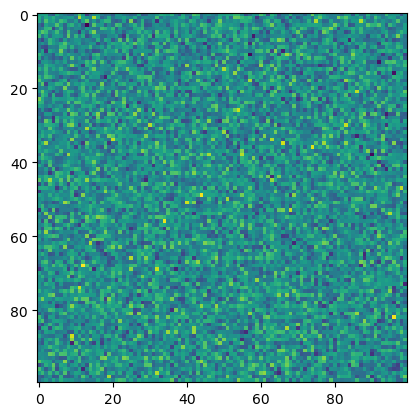

In [59]:
#genero numeri complessi 
#delta = N(0,1) * f :cioe distribuzione normale; f=sqrt(V*p(k)/2) (VEDERE QUAD)

phase = np.random.uniform(size=pks.shape)*2*np.pi

#phase.shape

#faccio la norma:
delta_k_norm = np.random.normal(size=pks.shape) * np.sqrt(pks*Volume/2)

delta_k = delta_k_norm * (np.cos(phase) + 1j*np.sin(phase))
plt.imshow(delta_k_norm[:,:,2])


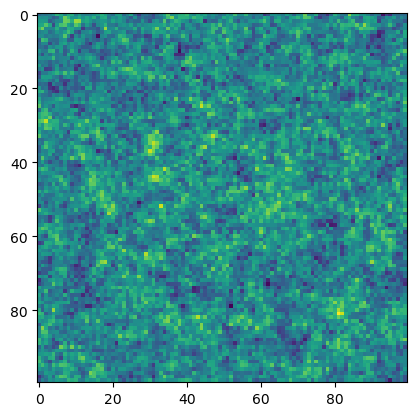

In [60]:
#faccio l'antitrasf
delta_x = np.fft.irfftn(delta_k, norm='backward')/spacing**3

plt.imshow(delta_x[:,:,2])

Text(0.5, 0, '$\\delta$')

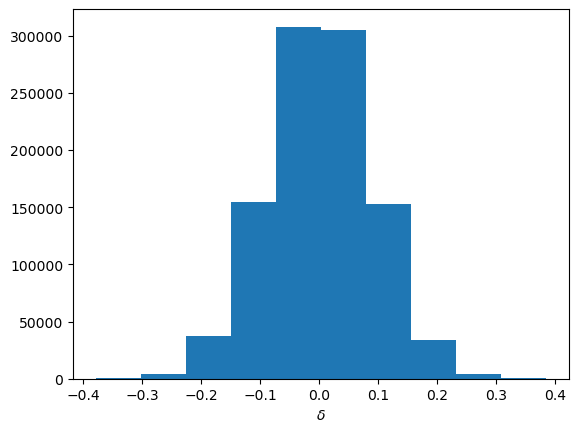

In [61]:
plt.hist(delta_x.flatten())
plt.xlabel(r"$\delta$")
#problema dei campi gaussiani
#se metto z =10 mi vengono valori della sbagliati 

## Extract Power Spectrum

In [62]:
knorm = []
for i in range(n_cells):
    kx = i if i <= n_cells//2 else i - n_cells #cioe se i < n_cells//2 allora kx = i altrimenti kx = i - n_cells
    kx *= 2*np.pi/side
    for j in range(n_cells):
        ky = j if j <= n_cells//2 else j - n_cells
        ky *= 2*np.pi/side
        for k in range(n_cells//2+1): #un po' diverso da prima perche ho solo valori positivi 
            kz = k * 2*np.pi/side
            knorm.append(np.sqrt(kx**2 + ky**2 + kz**2))

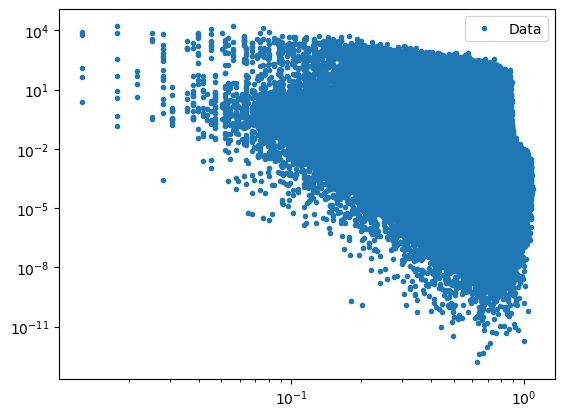

In [63]:
delta_k_sq = np.abs(delta_k)**2
pks = delta_k_sq.flatten()/Volume
plt.loglog(knorm, pks, '.', label='Data')
plt.legend(loc='best')


In [64]:
#definisco il binning
edges = np.arange(kF,kN,kF)

pk_meas = np.zeros(len(edges)-1)
k_bin = (edges[:-1] + edges[0:-1])/2

for i in range(len(k_bin)):
    k_selection = np.where((knorm >= edges[i]) & (knorm < edges[i+1])) #prendo solo i k che cascano dentro il bin (indice per indice)
    pk_meas[i] = np.mean(pks[k_selection])

/home/andrewcats/anaconda3/envs/acc-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/andrewcats/anaconda3/envs/acc-env/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Text(0, 0.5, '$P(k) [h^{-3} \\mathrm{Mpc}^{3}]$')

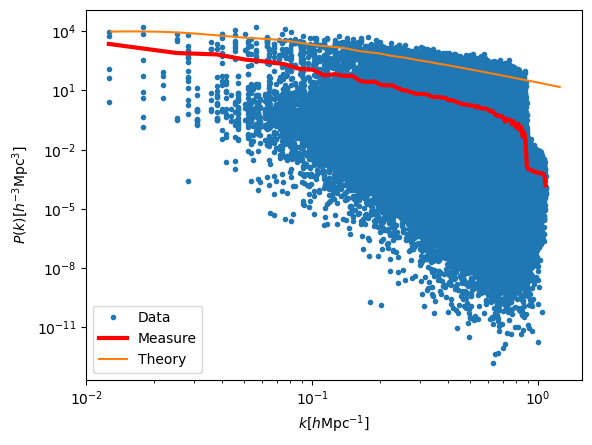

In [65]:
plt.loglog(knorm, pks, '.', label='Data')
plt.loglog(k_bin, pk_meas, '-', label='Measure',color='r', lw=3)
plt.loglog(kh[(kh>kF) & (kh<kN)], pk[0][(kh>kF) & (kh<kN)], label='Theory')
plt.legend(loc='best')
plt.xlabel(r"$k [h \mathrm{Mpc}^{-1}]$")
plt.ylabel(r"$P(k) [h^{-3} \mathrm{Mpc}^{3}]$")


* Lesson 12 (vedere quello che ha messoo Alfonso su git)

## Generate LogNormal Density field

In [66]:
#sigma_g è varianza del campo G(x)

knorm = np.reshape(knorm, newshape=(100, 100, 51))

In [67]:
knorm.shape
#knorm[56,72,21]

(100, 100, 51)

In [68]:
#Power Spectrum on the grid
pks = pk_interpolate(knorm)
pks.shape
#pks[56, 72, 21]

(100, 100, 51)

In [69]:
#now I obtain correlation function
#Get 2PCF on the grid
xi = np.fft.irfftn(pks)/spacing**3
xi.shape
#xi[1,1,1]


(100, 100, 100)

In [70]:
#make logaritmic trasfomation of the grid:
xi_g = np.log(1+xi) #this is the correlation function
#xi_g[1,1,1]

In [71]:
pk_g = np.fft.rfftn(xi_g) * spacing**3
pk_g.shape

(100, 100, 51)

In [72]:
#Generate G(k)
phase = np.random.uniform(size=pks.shape)*2*np.pi

G_k_norm = np.random.normal(size=pks.shape) * np.sqrt(pk_g*Volume)
G_k_norm[0,0,0] = 0
G_k = G_k_norm * (np.cos(phase) + 1j*np.sin(phase))

(array([1.0000e+00, 1.0000e+00, 2.0000e+00, 2.0000e+00, 1.0000e+00,
        2.0000e+00, 4.0000e+00, 5.0000e+00, 1.0000e+01, 5.0000e+00,
        1.1000e+01, 2.1000e+01, 4.9000e+01, 4.6000e+01, 8.6000e+01,
        8.9000e+01, 1.4300e+02, 1.8500e+02, 2.5200e+02, 3.4700e+02,
        4.6300e+02, 5.6800e+02, 7.6600e+02, 9.8000e+02, 1.3220e+03,
        1.6670e+03, 2.1820e+03, 2.7070e+03, 3.3030e+03, 4.0170e+03,
        4.8530e+03, 5.8010e+03, 7.2090e+03, 8.5790e+03, 1.0087e+04,
        1.1436e+04, 1.3417e+04, 1.5378e+04, 1.7607e+04, 1.9757e+04,
        2.1879e+04, 2.4117e+04, 2.6180e+04, 2.8337e+04, 3.0556e+04,
        3.2373e+04, 3.4240e+04, 3.5661e+04, 3.6420e+04, 3.7570e+04,
        3.8128e+04, 3.8494e+04, 3.8393e+04, 3.7797e+04, 3.7145e+04,
        3.5578e+04, 3.4142e+04, 3.2467e+04, 3.0757e+04, 2.8878e+04,
        2.6489e+04, 2.4197e+04, 2.1945e+04, 1.9669e+04, 1.7494e+04,
        1.5714e+04, 1.3586e+04, 1.1771e+04, 1.0156e+04, 8.5890e+03,
        7.2150e+03, 6.1610e+03, 4.9630e+03, 4.12

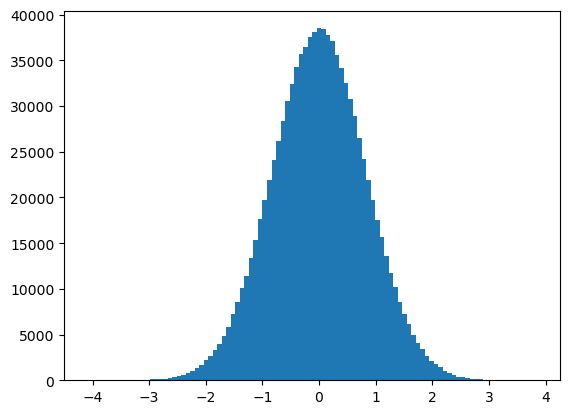

In [73]:
#Compute G(x)
G_x = np.fft.irfftn(G_k, norm='backward')/spacing**3
#G_x.shape
plt.hist(G_x.flatten(),histtype='bar', bins=100, label='G(x)')

(array([1.0000e+00, 1.0000e+00, 2.0000e+00, 2.0000e+00, 1.0000e+00,
        2.0000e+00, 4.0000e+00, 5.0000e+00, 1.0000e+01, 5.0000e+00,
        1.1000e+01, 2.1000e+01, 4.9000e+01, 4.6000e+01, 8.6000e+01,
        8.9000e+01, 1.4300e+02, 1.8500e+02, 2.5200e+02, 3.4700e+02,
        4.6300e+02, 5.6800e+02, 7.6600e+02, 9.8000e+02, 1.3220e+03,
        1.6670e+03, 2.1820e+03, 2.7070e+03, 3.3030e+03, 4.0170e+03,
        4.8530e+03, 5.8010e+03, 7.2090e+03, 8.5790e+03, 1.0087e+04,
        1.1436e+04, 1.3417e+04, 1.5378e+04, 1.7607e+04, 1.9757e+04,
        2.1879e+04, 2.4117e+04, 2.6180e+04, 2.8337e+04, 3.0556e+04,
        3.2373e+04, 3.4240e+04, 3.5661e+04, 3.6420e+04, 3.7570e+04,
        3.8128e+04, 3.8494e+04, 3.8393e+04, 3.7797e+04, 3.7145e+04,
        3.5578e+04, 3.4142e+04, 3.2467e+04, 3.0757e+04, 2.8878e+04,
        2.6489e+04, 2.4197e+04, 2.1945e+04, 1.9669e+04, 1.7494e+04,
        1.5714e+04, 1.3586e+04, 1.1771e+04, 1.0156e+04, 8.5890e+03,
        7.2150e+03, 6.1610e+03, 4.9630e+03, 4.12

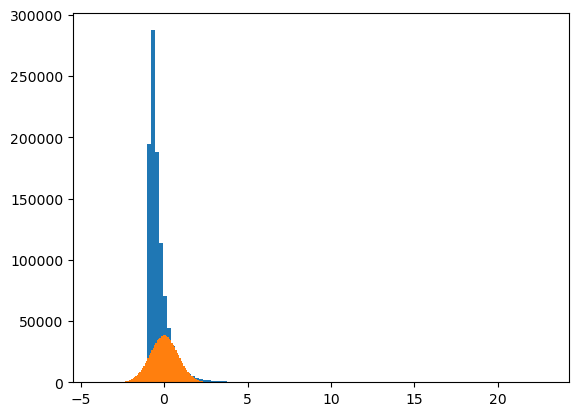

In [74]:
#Apply  lognormal transformation to get delta(x)
var_G = np.var(G_x)
delta_x = np.exp(G_x - var_G) - 1
plt.hist(delta_x.flatten(),histtype='bar', bins=100, label='delta(x)')
plt.hist(G_x.flatten(),histtype='bar', bins=100, label='xi(x)')

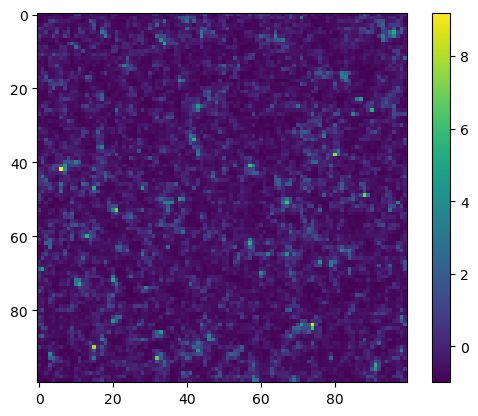

In [78]:
plt.imshow(delta_x[:,:,2])
plt.colorbar()
